# Previsione della Qualità dell'Aria in Cina

**Progetto di Data Intensive**  
**Autore:** Martin Tomassi, Jacopo Vasi  
**Email:** martin.tomassi@studio.unibo.it , jacopo.vasi@studio.unibo.it  
**Corso:** Data Intensive, Università di Bologna  
**Data:** Aprile 2025

## 1. Caricamento del Dataset

In [138]:
import os
import requests
import zipfile
import io
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output

N_JOBS = -1
RANDOM_STATE = 42


zip_path   = "archive.zip"
extract_to = "datasets/china"
os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("Estratti:")
for root, _, files in os.walk(extract_to):
    for f in files:
        print(os.path.join(root, f))


Estratti:
datasets/china\PRSA_Data_Aotizhongxin_20130301-20170228.csv
datasets/china\PRSA_Data_Changping_20130301-20170228.csv
datasets/china\PRSA_Data_Dingling_20130301-20170228.csv
datasets/china\PRSA_Data_Dongsi_20130301-20170228.csv
datasets/china\PRSA_Data_Guanyuan_20130301-20170228.csv
datasets/china\PRSA_Data_Gucheng_20130301-20170228.csv
datasets/china\PRSA_Data_Huairou_20130301-20170228.csv
datasets/china\PRSA_Data_Nongzhanguan_20130301-20170228.csv
datasets/china\PRSA_Data_Shunyi_20130301-20170228.csv
datasets/china\PRSA_Data_Tiantan_20130301-20170228.csv
datasets/china\PRSA_Data_Wanliu_20130301-20170228.csv
datasets/china\PRSA_Data_Wanshouxigong_20130301-20170228.csv


Unione dei vari CSV in un unico file

In [141]:
csv_folder = extract_to  
output_file = 'combined_dataset.csv'


csv_files = [f for f in os.listdir(csv_folder) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files.")


dfs = []
for file in csv_files:
    path = os.path.join(csv_folder, file)
    try:
        df = pd.read_csv(path)
        dfs.append(df)
        print(f"Loaded {file} with {len(df)} rows.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not dfs:
    raise ValueError("No CSV files were successfully loaded.")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined DataFrame has {len(combined_df)} rows and {len(combined_df.columns)} columns.")


combined_df.to_csv(output_file, index=False)
print(f"\nCombined CSV saved to: {output_file}")

Found 12 CSV files.
Loaded PRSA_Data_Aotizhongxin_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Changping_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Dingling_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Dongsi_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Guanyuan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Gucheng_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Huairou_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Nongzhanguan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Shunyi_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Tiantan_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Wanliu_20130301-20170228.csv with 35064 rows.
Loaded PRSA_Data_Wanshouxigong_20130301-20170228.csv with 35064 rows.

Combined DataFrame has 420768 rows and 18 columns.

Combined CSV saved to: combined_dataset.csv


# Dataset sulla **Qualità dell'Aria in Cina**



Il dataset in questione è stato messo a disposizione dal Beijing Municipal Environmental Monitoring Center, l’ente ufficiale del Governo Cinese deputato al monitoraggio e alla gestione dell’inquinamento atmosferico, al fine di raccogliere informazioni relative alle condizioni della qualità dell’aria nel distretto di Beijing nel periodo compreso tra il 2013 e il 2017.

Sempre citando la documentazione ufficiale, il dataset permette di indagare su numerose variabili ambientali e parametri atmosferici che includono:

- PM10 e PM2.5: concentrazioni di particolato in ug/m³;
- CO: monossido di carbonio (mg/m³);
- NO₂: biossido di azoto (ug/m³);
- SO₂: anidride solforosa (ug/m³);
- O3: concentrazione di Ozono (ug/m^3);
- Parametri meteorologici e ambientali quali temperatura, pressione barometrica, temperatura del punto di rugiada, precipitazioni, velocità e direzione del vento.

Si procede alla lettura del file contenente le informazioni relative alle varie stazioni di monitoraggio. Successivamente, verranno rimosse alcune colonne ritenute non necessarie per l'analisi in corso, al fine di semplificare la struttura del dataset ed enfatizzare solo le informazioni rilevanti.

In [145]:
dataframe = pd.read_csv(f'combined_dataset.csv')
dataframe.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [146]:
dataframe.drop(columns=['No'], inplace=True)
dataframe.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


Si crea una lista di tutti i distretti presenti nel dataset, assicurandosi di includere ciascun nome una sola volta. Questo passaggio fornisce una visione d’insieme delle regioni coperte dai dati, supportando analisi geografiche e suddivisioni successive.

In [151]:
unique_cities = dataframe['station'].unique()
unique_cities

array(['Aotizhongxin', 'Changping', 'Dingling', 'Dongsi', 'Guanyuan',
       'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi', 'Tiantan',
       'Wanliu', 'Wanshouxigong'], dtype=object)

Successivamente si crea una vista del numero di entry per ogni distretto. Questo passaggio fornisce una visone dell'uniformità del quantitativo dei dati presenti in ogni distretto.

[12] different cities and [420768] total records available.


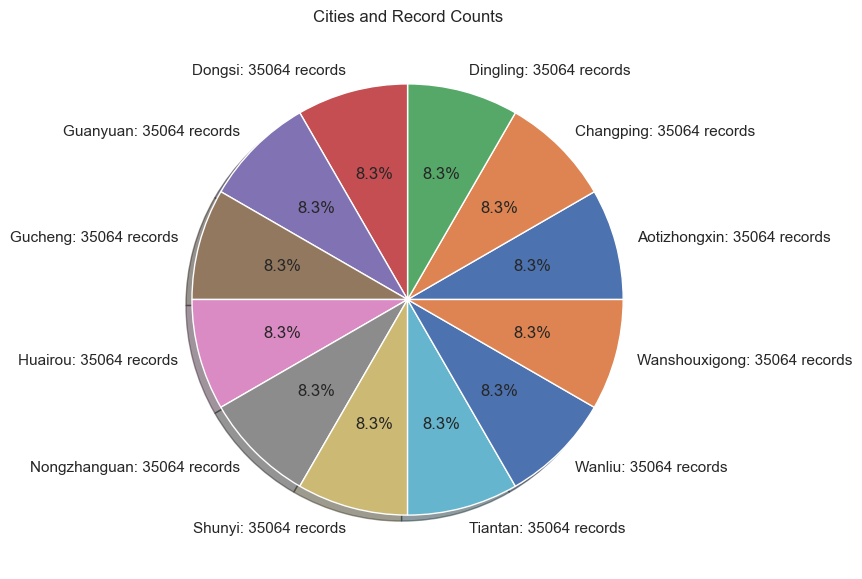

In [154]:
# Quick overview
print(f"[{dataframe['station'].nunique()}] different cities and [{dataframe['station'].count()}] total records available.")

# Get city counts
cities = dataframe["station"].value_counts()

cities.plot.pie(
    labels=[f"{c}: {p} records" for c, p in zip(cities.index, cities.values)],
    autopct="%.1f%%",
    shadow=True,
    figsize=(7,7),
    title="Cities and Record Counts"
);
plt.ylabel('');
plt.show()

Unione delle colonne temporali

In [159]:
dataframe['datetime'] = pd.to_datetime(
    dataframe[['year', 'month', 'day', 'hour']],
    errors='coerce'
)

# (Optional) Drop the original columns if you no longer need them
dataframe.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Preview the result
dataframe.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,wind_quadrant,datetime
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,N,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,N,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,N,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,NW,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,N,2013-03-01 04:00:00


## Pre-elaborazione dei dati

#### Utilizzo di ‘datetime’ come indice temporale

Per gestire efficacemente le serie storiche, viene utilizzata la colonna `datetime` come indice datetime.

In [162]:
dataframe = dataframe.rename(columns={'station': 'District'})
dataframe = dataframe.set_index('datetime')
dataframe.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,District,wind_quadrant
datetime,,,,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,N
2013-03-01 01:00:00,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,N
2013-03-01 02:00:00,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,N
2013-03-01 03:00:00,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,NW
2013-03-01 04:00:00,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,N


### Verifica dei valori mancanti

Il primo passo consiste nel quantificare quanti dati mancanti siano presenti per ciascuna delle feature selezionate.

In [168]:
dataframe.isnull().sum().sort_values(ascending=False)


CO               20701
O3               13277
NO2              12116
SO2               9021
PM2.5             8739
PM10              6449
wd                1822
DEWP               403
TEMP               398
PRES               393
RAIN               390
WSPM               318
District             0
wind_quadrant        0
dtype: int64

In [170]:
df=dataframe
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [172]:
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percentage of Missing Values (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

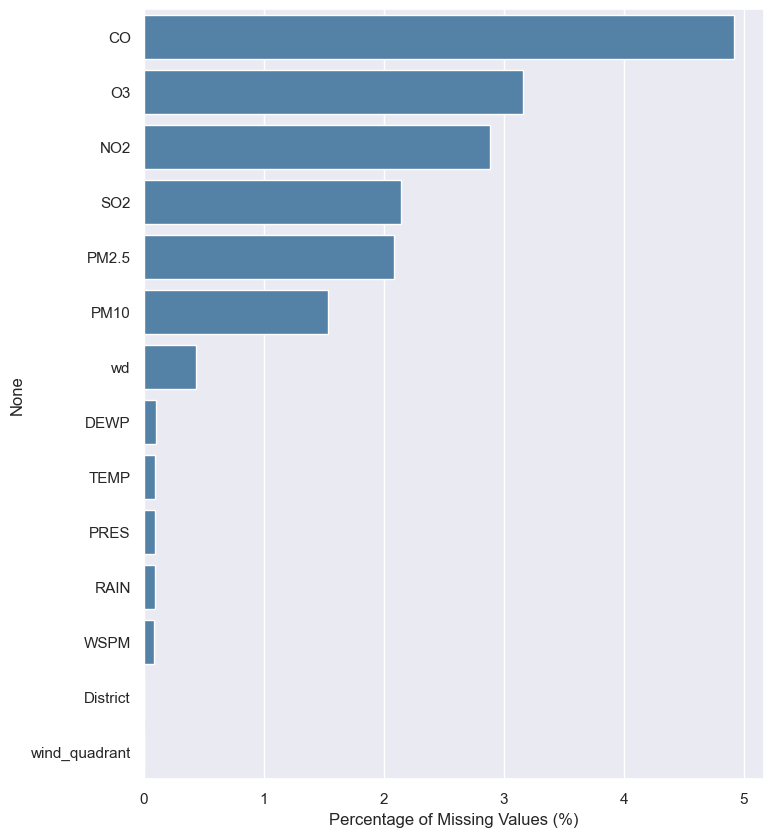

In [174]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percentage of Missing Values (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

### Eliminare i valori mancanti per soglia

Non essendoci colonne al di sopra di una certa soglia (>40%) non viene eliminato nulla.

### Analisi esplorativa dei dati

Sto raccogliendo le metriche iniziali in diversi gruppi. Ciò consentirà di effettuare confronti migliori.

In [187]:
pollutants = {
    'Particulate Matter' : ['PM2.5', 'PM10'],
    'Nitrogen Compounds' : ['NO2'],
    'Carbon Monoxide': ['CO'],
    'Sulfur Dioxide': ['SO2'],
    'Ozone Concentration' : ['O3']
}
other_metrics = {
    'Pressure' : ['PRES'],
    'Temperatures' : ['TEMP'],
    'Dew Point Temperature' : ['DEWP'],
    'Rainfall' : ['RAIN'],
    'Wind Direction' : ['wd'],
    'Wind Speed' : ['WSPM']
}

### Frequenze temporali

Cominciamo a raggruppare il nostro DataFrame per varie frequenze temporali.

In [190]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [192]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

        

            data_slice.plot(kind="line", ax=ax)

            for column in data_slice.columns:
                labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

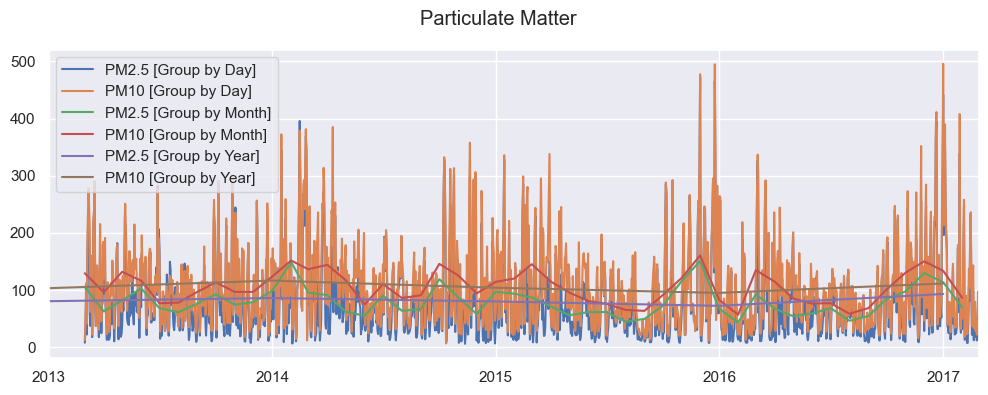

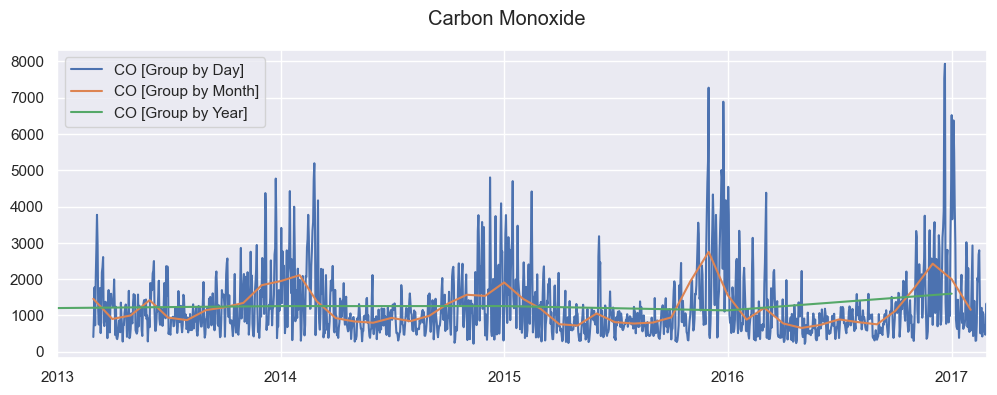

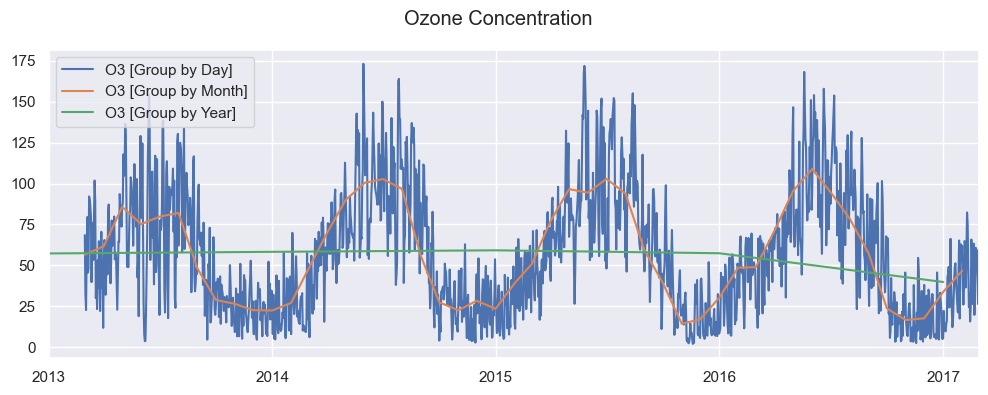

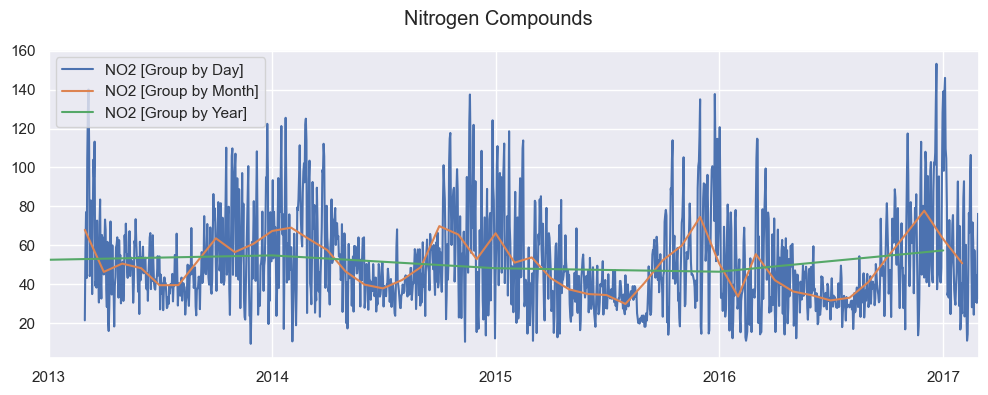

In [194]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

### Analisi stagionale su base annua
Dalle metriche selezionate emergono potenziali pattern di tipo stagionale. Per approfondire questa osservazione, eseguiamo un’analisi dettagliata delle variazioni stagionali nell’arco di un anno. Come punto di partenza, prenderemo in considerazione un sottoinsieme di dati relativo al periodo 2016–2017.

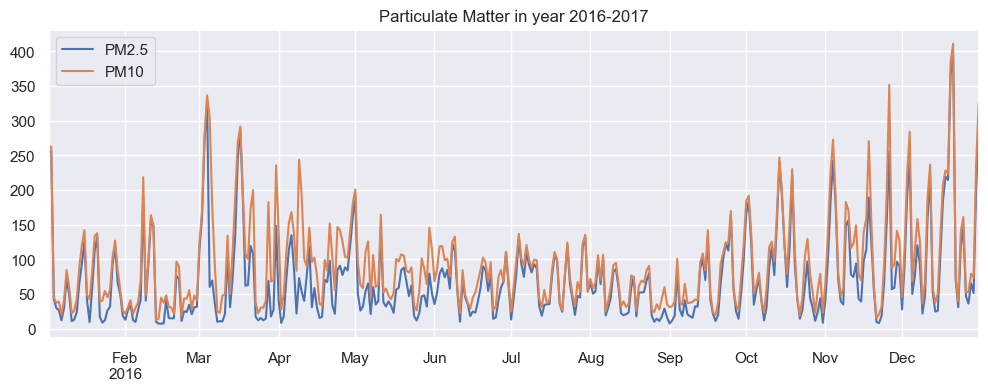

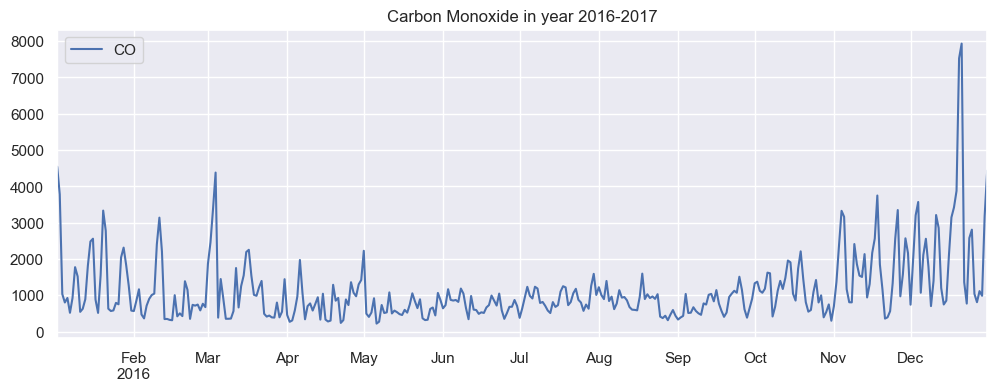

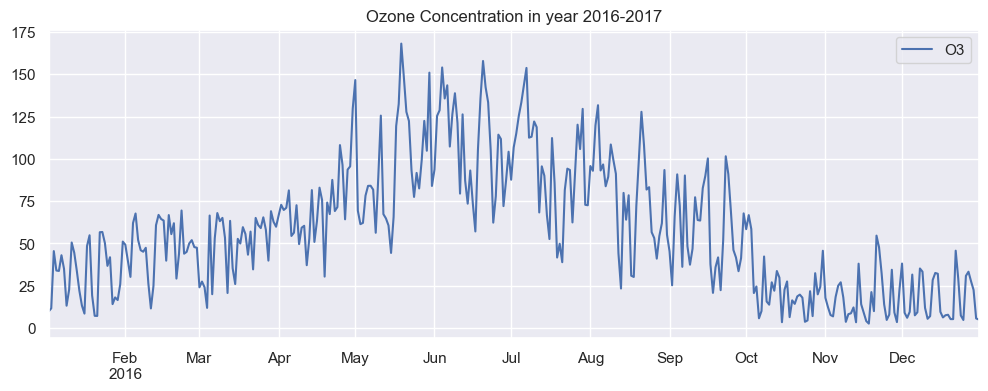

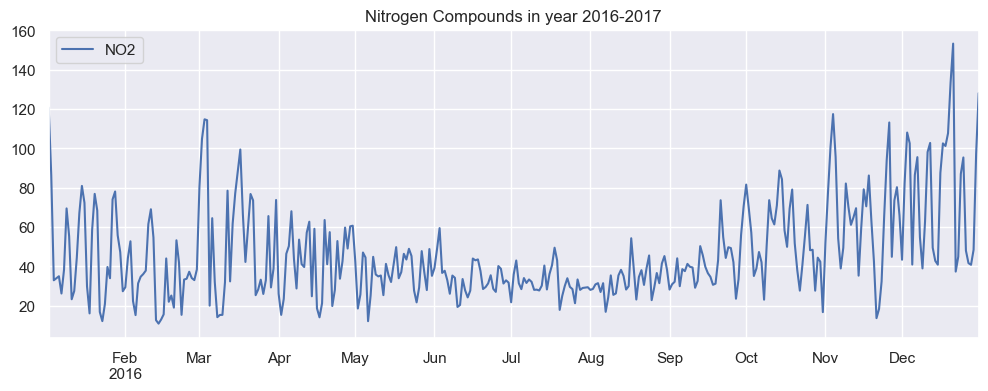

In [197]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2016 and datetime < 2017').plot(title=f'{feature} in year 2016-2017', figsize=(12,4)).set(xlabel=None)

Si osserva un incremento nei valori di `Particulate Matter`, `Nitrogen Compounds` e `Carbon Monoxide` a partire da ottobre, con un picco che tende a persistere fino circa a marzo. Al contrario, la `Ozone Concentration` mostra un comportamento opposto, raggiungendo i valori massimi indicativamente tra maggio e giugno.

### PairPlot
Andiamo ad utilizzare il grafico a coppie, che ci consente di visualizzare in modo più chiaro le relazioni bivariate tra le variabili, nonché la distribuzione univariata di ciascuna di esse.

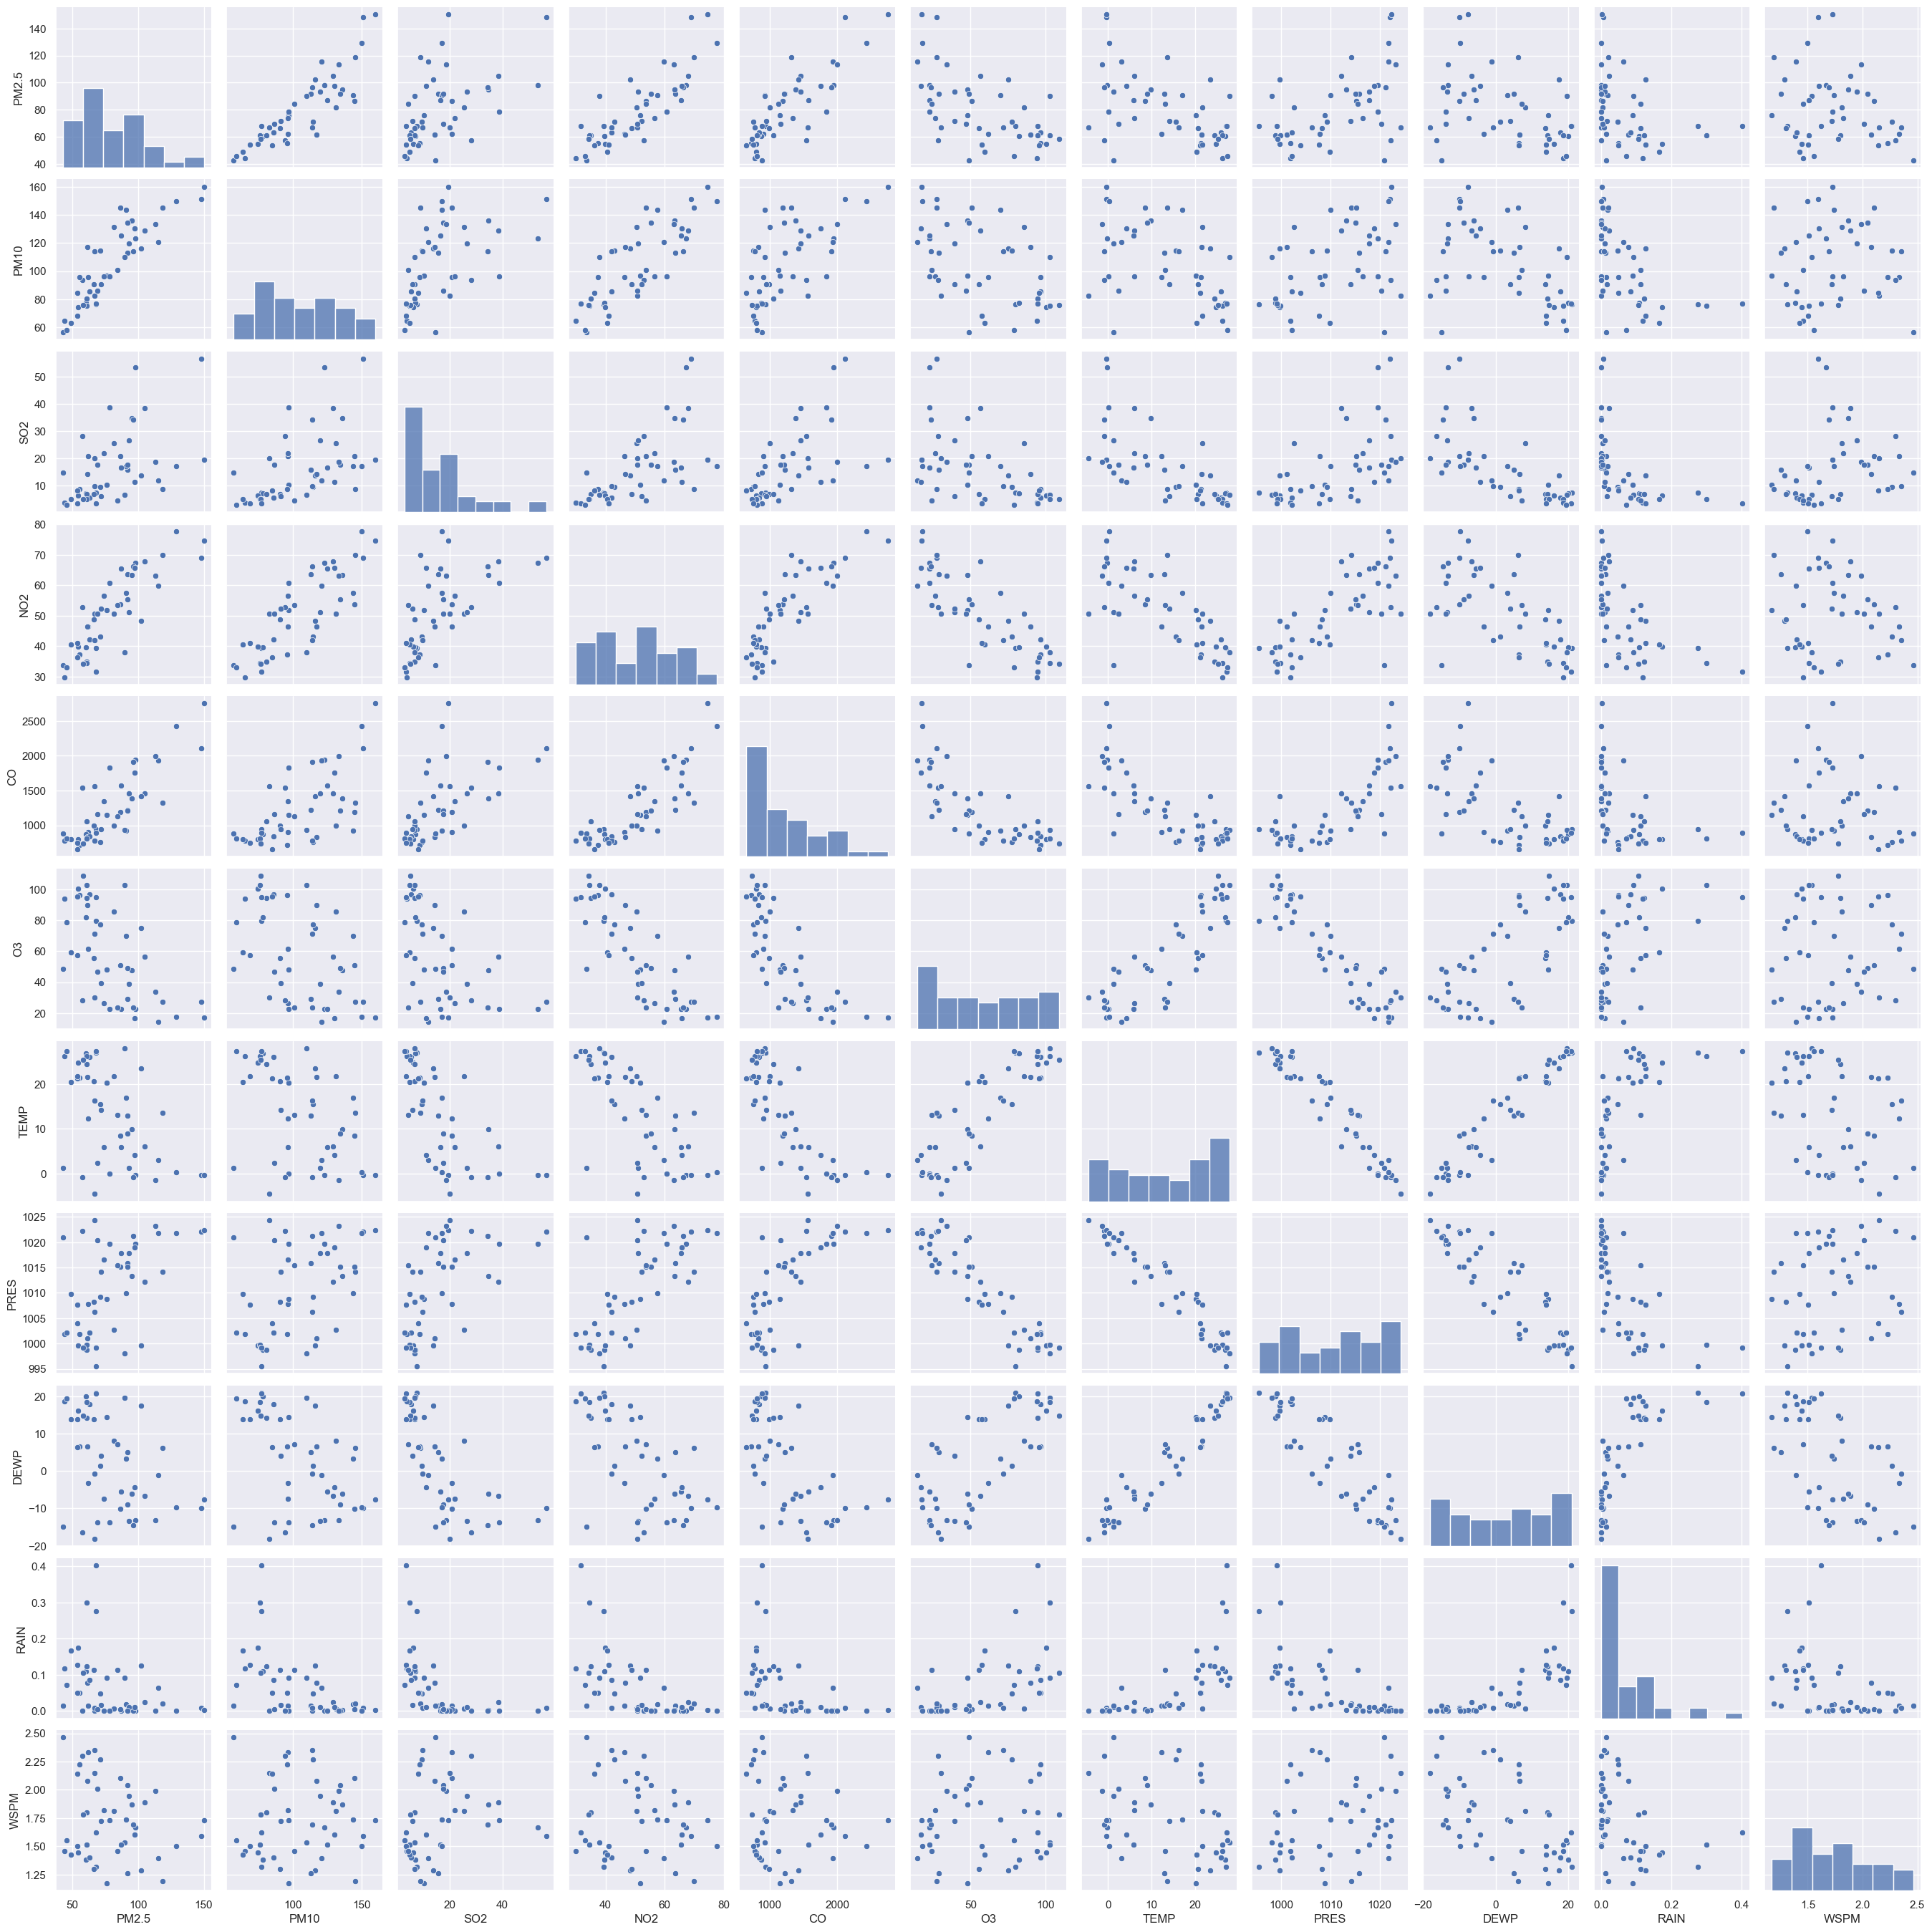

In [201]:
sns.pairplot(slice_groups['Group by Month'])

### Matrice di correlazione
Ora, andiamo ad utilizzare la matrice di correlazione che offre una rappresentazione sintetica ed efficace del grado di associazione lineare tra le diverse variabili del dataset.

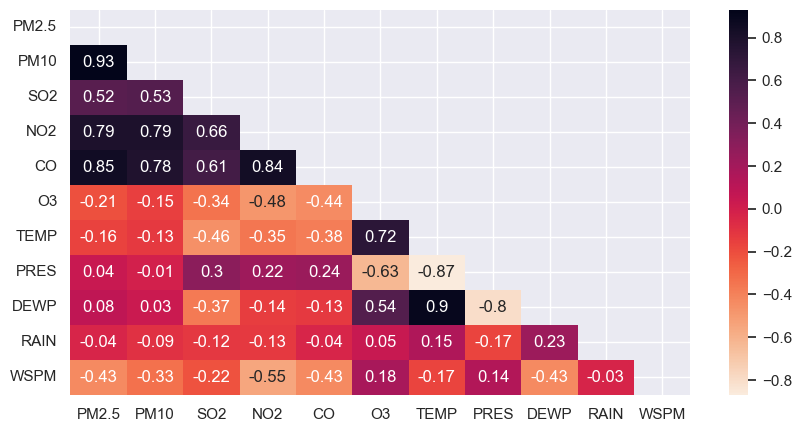

In [204]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [205]:
corr_target = abs(corr['PM2.5'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5    1.00
PM10     0.93
CO       0.85
NO2      0.79
SO2      0.52
WSPM     0.43
Name: PM2.5, dtype: float64

Il grafico evidenzia diverse correlazioni significative tra le variabili. 

Vengono raggruppare le direzioni cardinali del vento mostrando la loro influenza sulla concentrazione di PM2.5

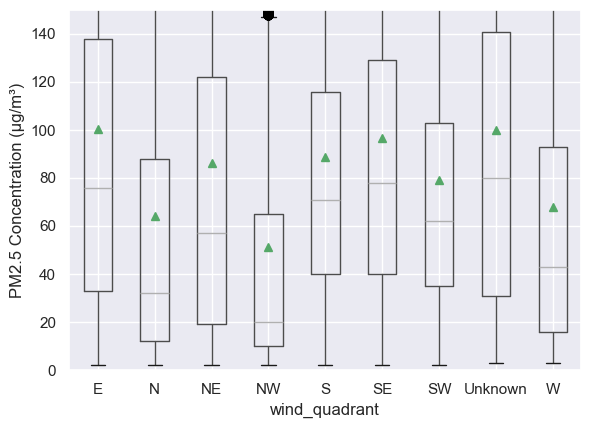

TypeError: 'NoneType' object does not support item assignment

In [333]:
# Apply to the dataframe
def wind_quadrant_str(direction):
    if pd.isna(direction):
        return "Unknown"
    direction = direction.upper()
    
    if direction in ['N', 'NNE', 'NNW']:
        return "N"
    elif direction in ['NE']:
        return "NE"
    elif direction in ['E', 'ENE', 'ESE']:
        return "E"
    elif direction in ['NW']:
        return "NW"
    elif direction in ['S', 'SSE', 'SSW']:
        return "S"
    elif direction in ['SE']:
        return "SE"
    elif direction in ['W', 'WNW', 'WSW']:
        return "W"
    elif direction in ['SW']:
        return "SW"
    else:
        return "Other"

# Apply to the dataframe
dataframe["wind_quadrant"] = dataframe["wd"].apply(wind_quadrant_str)

# Boxplot
quartiles_pollution = dataframe.boxplot(column="PM2.5", by="wind_quadrant", showmeans=True)
quartiles_pollution.set_ylabel("PM2.5 Concentration (µg/m³)")
quartiles_pollution.set_title("")
plt.suptitle("")
plt.ylim(0, 150)  # adjust depending on your dataset range
plt.show()["wind_quadrant"] = dataframe["wd"].apply(wind_quadrant_str)


## Feature Engineering



### Resampling
Poiché il dataframe combinato include misurazioni provenienti da diverse località all'interno dello stesso stato e riferite agli stessi intervalli temporali, è possibile che si verifichino duplicazioni temporali. Dal momento che l’obiettivo è analizzare la qualità dell’aria a livello statale, procederemo con un ricampionamento temporale aggregando i dati mediante media delle misurazioni corrispondenti allo stesso timestamp.

In [212]:
df = df.resample('60min').mean(numeric_only=True)

### Rilevamento e rimozione degli outlier
Gli outlier rappresentano valori anomali che si discostano in modo significativo dalla distribuzione generale dei dati. La loro presenza può compromettere l’accuratezza delle analisi statistiche e influenzare negativamente le prestazioni dei modelli predittivi. L’identificazione e la rimozione degli outlier consente di ottenere risultati più affidabili e modelli previsionali più robusti.

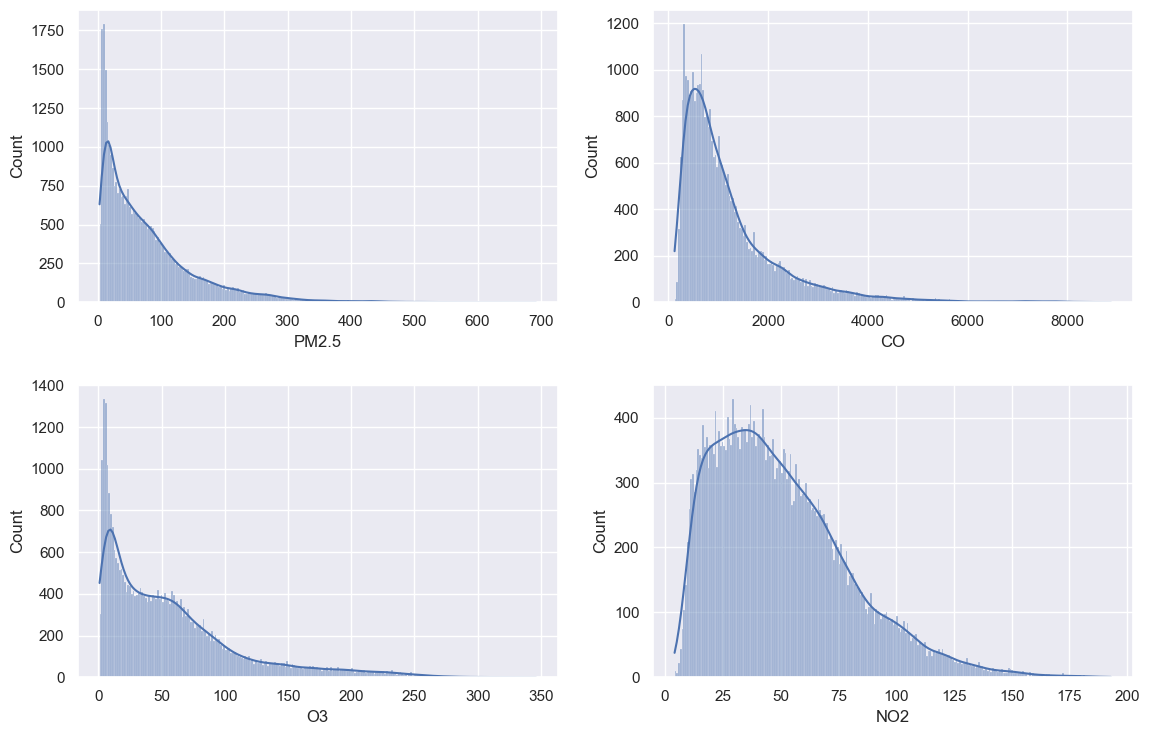

In [215]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['O3'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NO2'], bins=250, kde=True, ax=axes[1,1])

plt.show()

La prima feature che esploreremo è il `PM2,5`.

<Axes: xlabel='datetime'>

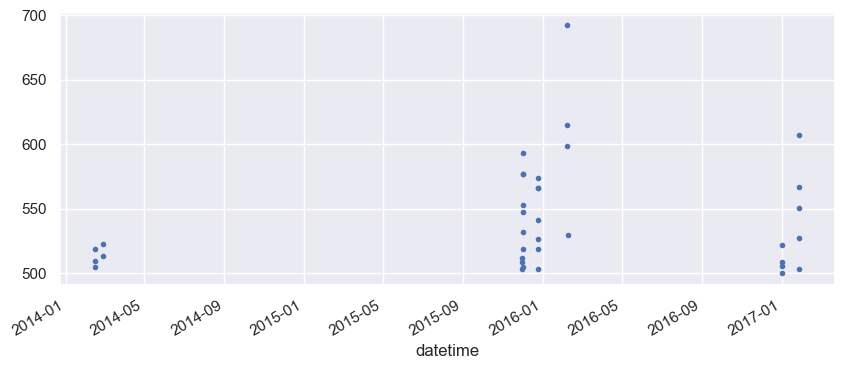

In [246]:
df.query('`PM2.5` > 500')['PM2.5'].plot(style='.', figsize=(10,4))

Si osserva la presenza di alcuni outlier con valori superiori a 950, concentrati intorno all’anno 2012. Considerata la loro natura anomala, si procede con la loro rimozione al fine di migliorare la qualità dell’analisi.

In [248]:
df['PM2.5'] = df['PM2.5'].mask(df['PM2.5'].gt(950))

Successivamente, esploriamo i potenziali outlier sulla feature del `CO`.

<Axes: xlabel='datetime'>

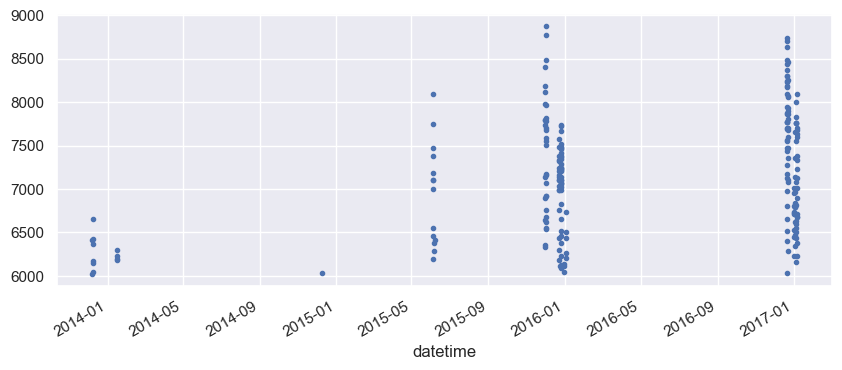

In [253]:
df.query('`CO` > 6000')['CO'].plot(style='.', figsize=(10,4))

Si può notare una significativa variabilità in questa feature. Tuttavia, un gruppo situato sulla parte destra del grafico, dopo l'anno 2015, ha suscitato il nostro interesse. Pertanto, optiamo per escluderlo.

In [256]:
df['CO'] = df['CO'].mask(((df.index > '2015') & df['CO'].gt(35)))

Esploriamo anche la feature dell' `Ozone`.

<Axes: xlabel='datetime'>

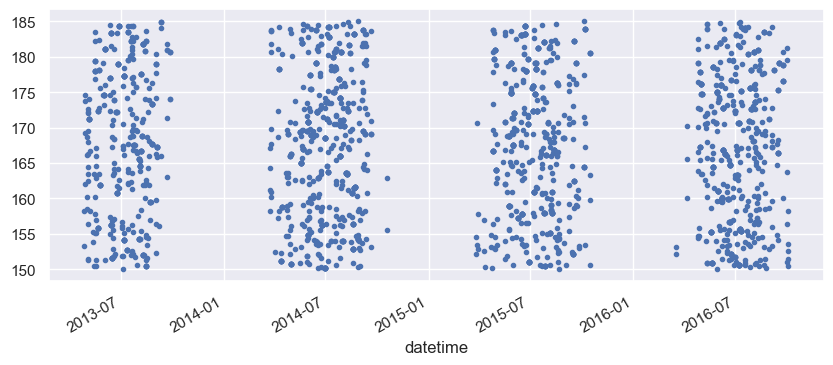

In [309]:
df.query('`O3` > 150')['O3'].plot(style='.', figsize=(10,4))

Gli outliers sembrano essere presenti esclusivamente nella metà del 2016. Pertanto, procederemo con la rimozione di questi valori anomali relativi a tale periodo.

In [270]:
df['O3'] = df['O3'].mask(df['O3'].gt(185))

Infine, diamo un'occhiata alla feature `NOx`.

<Axes: xlabel='datetime'>

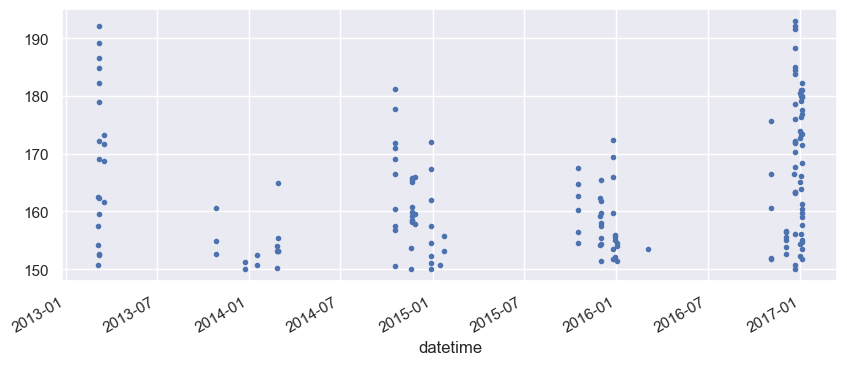

In [273]:
df.query('`NO2` > 150')['NO2'].plot(style='.', figsize=(10,4))

Anche in questa situazione, osserviamo solo alcuni outliers che sembrano essere misurazioni errate. Decidiamo quindi di eliminarli.

In [276]:
df['NO2'] = df['NO2'].mask((
    ((df.index < '2014') & (df['NO2'].gt(380))) |
    ((df.index > '2016') & (df.index < '2017') & (df['NO2'].gt(400))) |
    ((df.index > '2017') & (df['NO2'].gt(450)))
))

### Gestione dei valori mancanti

In [279]:
get_null_info(df)

,Null Count,Percentage of Missing Values (%)
CO,19107,54.49
O3,1563,4.46
SO2,87,0.25
NO2,87,0.25
PM10,83,0.24
PM2.5,81,0.23
TEMP,18,0.05
PRES,18,0.05
DEWP,18,0.05
RAIN,18,0.05


In [281]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Freq: 60min
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   35064 non-null  float64
 1   PM10    35064 non-null  float64
 2   SO2     35064 non-null  float64
 3   NO2     35064 non-null  float64
 4   CO      35064 non-null  float64
 5   O3      35064 non-null  float64
 6   TEMP    35064 non-null  float64
 7   PRES    35064 non-null  float64
 8   DEWP    35064 non-null  float64
 9   RAIN    35064 non-null  float64
 10  WSPM    35064 non-null  float64
dtypes: float64(11)
memory usage: 3.2 MB


C:\Users\jacop\AppData\Local\Temp\ipykernel_22872\1820669235.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='pad')


### Arricchimento del Dataset con Caratteristiche Aggiuntive
Procediamo con l'ampliamento del nostro dataset, integrando nuove features che possano risultare utili.

In [284]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [286]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

Ora, grazie alle features precedentemente descritte, è semplice visualizzare le diverse metriche. Ad esempio, possiamo esaminare la qualità dell'aria nel corso dei mesi utilizzando un boxplot.

In [289]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, hue=time_group, palette="icefire", showfliers=False, legend=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

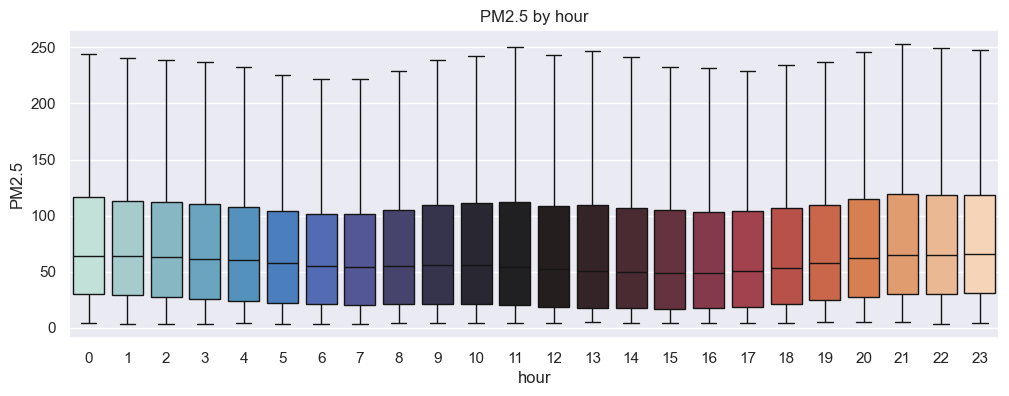

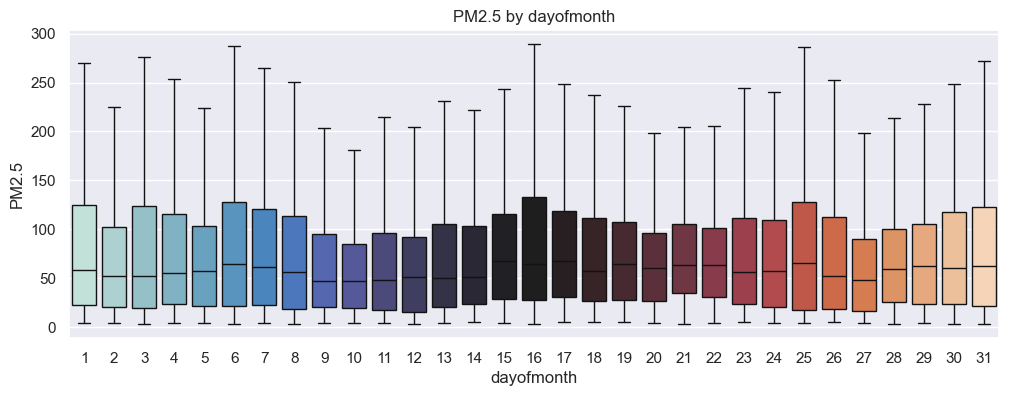

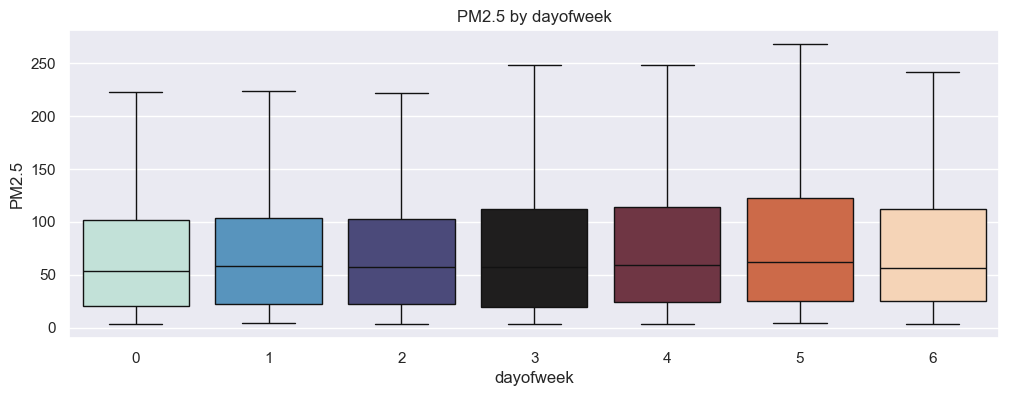

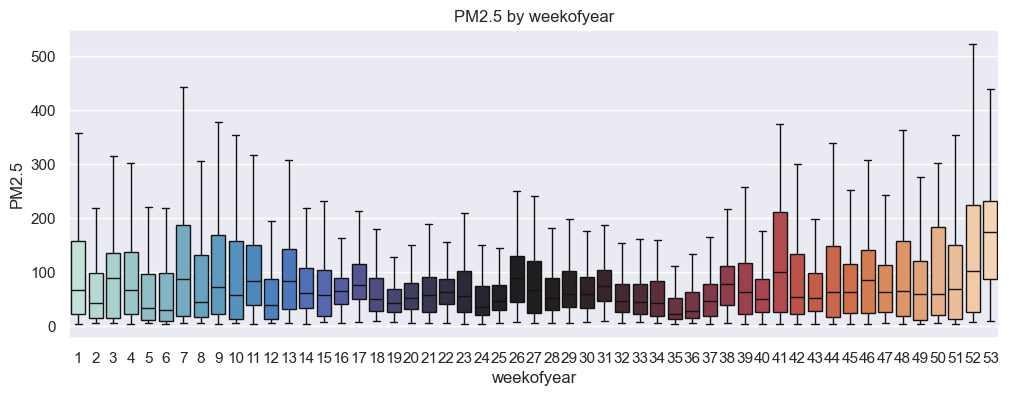

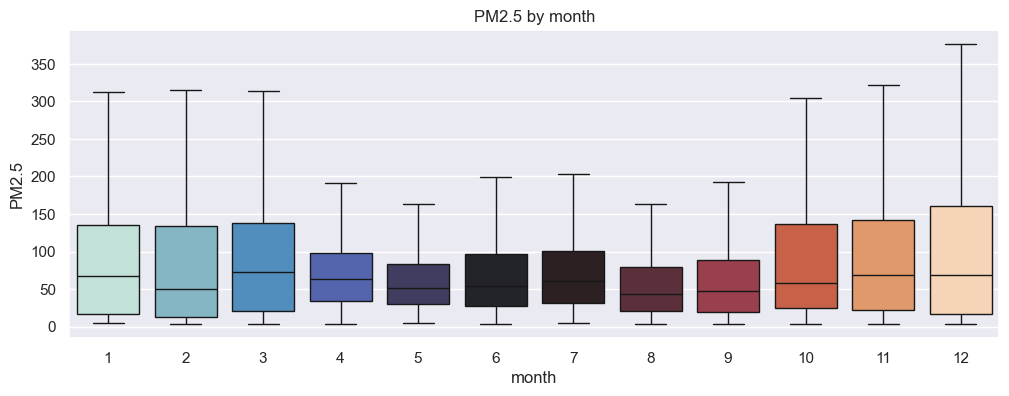

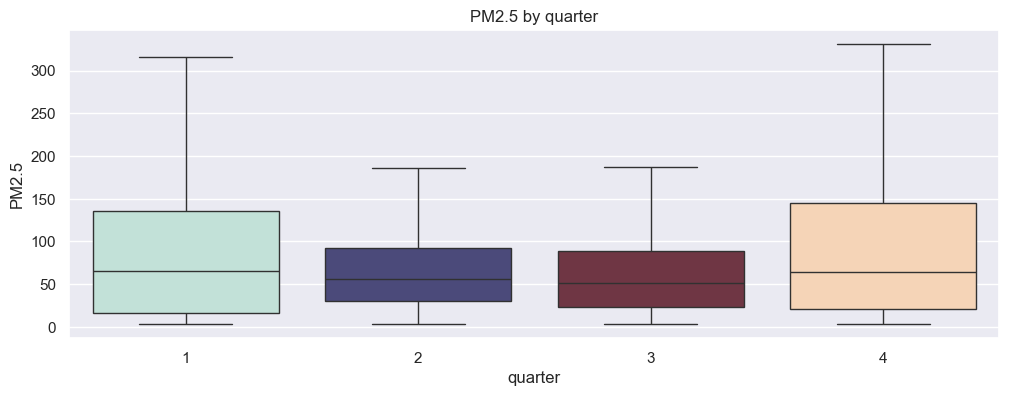

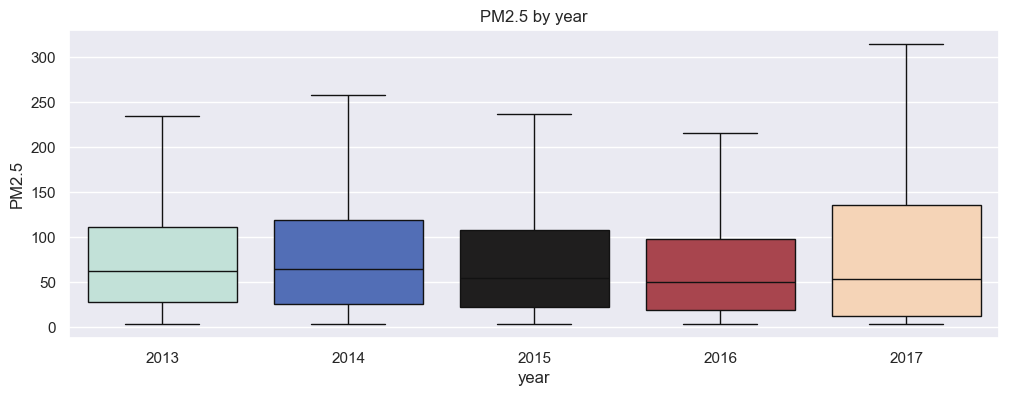

In [291]:
plot_by_datetime('PM2.5', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

I grafici mostrano chiaramente che i vari gruppi di date catturano tendenze e informazioni significative. Un punto interessante è che il vettore di feature `dayofweek` potrebbe non essere così rilevante, dato che la distribuzione appare simile per tutti i giorni della settimana. Tuttavia, includeremo comunque tutte queste informazioni nel nostro modello.

### Lag Features

Le cosiddette “lag features” consentono di includere nei modelli i valori storici di una variabile, risultando spesso determinanti nelle previsioni grazie al loro elevato potere predittivo. Possiamo inoltre generare lag anche per altre variabili significative, ampliando il contesto informativo del dataset e potenzialmente migliorando la precisione delle stime.

Analizzando i boxplot, abbiamo osservato che alcune feature evidenziano trend stagionali o andamenti rilevanti nel tempo. Sulla base di queste evidenze, creeremo lag features mirate per sfruttare al meglio tali pattern.

In [293]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5'].shift(730*24)   # 2 year lag
    return df

In [294]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = create_lag_features(df)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,pm_lag_1Y,pm_lag_2Y
datetime,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,5.666667,7.916667,5.666667,12.600000,308.333333,75.416667,-0.916667,1022.766667,-19.900000,0.0,...,0,1,4,60,9,3,1,2013,NaN,NaN
2013-03-01 01:00:00,6.833333,9.833333,5.333333,13.111111,308.333333,75.750000,-1.216667,1023.191667,-19.916667,0.0,...,1,1,4,60,9,3,1,2013,NaN,NaN
2013-03-01 02:00:00,5.666667,7.250000,8.166667,12.900000,300.000000,66.000000,-1.591667,1023.325000,-21.008333,0.0,...,2,1,4,60,9,3,1,2013,NaN,NaN
2013-03-01 03:00:00,6.000000,9.250000,5.833333,12.400000,283.333333,75.333333,-1.891667,1024.208333,-21.833333,0.0,...,3,1,4,60,9,3,1,2013,NaN,NaN
2013-03-01 04:00:00,4.833333,6.916667,6.750000,14.000000,308.333333,66.333333,-2.283333,1024.866667,-21.625000,0.0,...,4,1,4,60,9,3,1,2013,NaN,NaN


A seguito della creazione delle lag features, riscontriamo che i primi record del dataset presentano valori mancanti: ciò è inevitabile, dato che non esistono dati storici precedenti per calcolare i ritardi temporali. È quindi fondamentale gestire con cura questi missing values, poiché molti algoritmi predittivi non possono elaborare dati incompleti. Per affrontare questo problema, implementeremo una funzione dedicata al trattamento dei NaN generati dai lag, tenendo presente che questa operazione, pur necessaria per confrontare le performance dei modelli, potrebbe introdurre bias o comportare la perdita di informazioni nei periodi iniziali di raccolta.

In [299]:
def replace_lag_na(df, how):
    if how == 'zeros':
        return df.fillna(0)
    if how == 'drop':
        return df.dropna(how='any')